In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



2023-12-09 09:49:22.994780: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
token = pd.read_csv("BTC_GBP_hourly.csv")

In [3]:
token.head()

time     high      low     open  volumefrom   volumeto    close  \
0  10/29/19 07:00  7393.60  7343.82  7356.09       13.65  100385.89  7372.48   
1  10/29/19 08:00  7376.57  7327.54  7372.48       39.24  289588.03  7367.00   
2  10/29/19 09:00  7367.00  7320.44  7367.00       61.71  454325.00  7343.10   
3  10/29/19 10:00  7418.84  7340.33  7343.10       23.79  175654.64  7384.95   
4  10/29/19 11:00  7384.95  7326.57  7384.95       24.16  177663.12  7355.92   

  conversionType conversionSymbol  
0         direct              NaN  
1         direct              NaN  
2         direct              NaN  
3         direct              NaN  
4         direct              NaN

In [4]:
token.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35722 entries, 0 to 35721
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   time              35722 non-null  object 
 1   high              35722 non-null  float64
 2   low               35722 non-null  float64
 3   open              35722 non-null  float64
 4   volumefrom        35722 non-null  float64
 5   volumeto          35722 non-null  float64
 6   close             35722 non-null  float64
 7   conversionType    35722 non-null  object 
 8   conversionSymbol  441 non-null    object 
dtypes: float64(6), object(3)
memory usage: 2.5+ MB


In [5]:
token.columns

Index(['time', 'high', 'low', 'open', 'volumefrom', 'volumeto', 'close',
       'conversionType', 'conversionSymbol'],
      dtype='object')

In [6]:
token.isnull().sum()

time                    0
high                    0
low                     0
open                    0
volumefrom              0
volumeto                0
close                   0
conversionType          0
conversionSymbol    35281
dtype: int64

In [7]:
token = token.drop(columns = ['conversionType', 'conversionSymbol'])

In [8]:
token

time      high       low      open  volumefrom   volumeto  \
0      10/29/19 07:00   7393.60   7343.82   7356.09      13.650  100385.89   
1      10/29/19 08:00   7376.57   7327.54   7372.48      39.240  289588.03   
2      10/29/19 09:00   7367.00   7320.44   7367.00      61.710  454325.00   
3      10/29/19 10:00   7418.84   7340.33   7343.10      23.790  175654.64   
4      10/29/19 11:00   7384.95   7326.57   7384.95      24.160  177663.12   
...               ...       ...       ...       ...         ...        ...   
35717  11/24/23 20:00  30073.25  29954.58  29973.25      19.400  582271.50   
35718  11/24/23 21:00  30102.65  29990.04  30028.34       7.582  227923.24   
35719  11/24/23 22:00  30034.10  29895.08  30008.21       6.091  182449.36   
35720  11/24/23 23:00  29935.62  29823.99  29920.38       7.370  220250.81   
35721  11/25/23 00:00  29981.06  29902.48  29922.60       2.209   66128.99   

          close  
0       7372.48  
1       7367.00  
2       7343.10  
3       7384.95  
4       7355.92  
...         ...  
35717  30028.34  
35718  30008.21  
35719  29920.38  
35720  29922.60  
35721  29934.84  

[35722 rows x 7 columns]

In [9]:
token['time'] = pd.to_datetime(token['time'])
token = token.set_index('time')
token = token.sort_index()


In [10]:
token

high       low      open  volumefrom   volumeto  \
time                                                                       
2019-10-29 07:00:00   7393.60   7343.82   7356.09      13.650  100385.89   
2019-10-29 08:00:00   7376.57   7327.54   7372.48      39.240  289588.03   
2019-10-29 09:00:00   7367.00   7320.44   7367.00      61.710  454325.00   
2019-10-29 10:00:00   7418.84   7340.33   7343.10      23.790  175654.64   
2019-10-29 11:00:00   7384.95   7326.57   7384.95      24.160  177663.12   
...                       ...       ...       ...         ...        ...   
2023-11-24 20:00:00  30073.25  29954.58  29973.25      19.400  582271.50   
2023-11-24 21:00:00  30102.65  29990.04  30028.34       7.582  227923.24   
2023-11-24 22:00:00  30034.10  29895.08  30008.21       6.091  182449.36   
2023-11-24 23:00:00  29935.62  29823.99  29920.38       7.370  220250.81   
2023-11-25 00:00:00  29981.06  29902.48  29922.60       2.209   66128.99   

                        close  
time                           
2019-10-29 07:00:00   7372.48  
2019-10-29 08:00:00   7367.00  
2019-10-29 09:00:00   7343.10  
2019-10-29 10:00:00   7384.95  
2019-10-29 11:00:00   7355.92  
...                       ...  
2023-11-24 20:00:00  30028.34  
2023-11-24 21:00:00  30008.21  
2023-11-24 22:00:00  29920.38  
2023-11-24 23:00:00  29922.60  
2023-11-25 00:00:00  29934.84  

[35722 rows x 6 columns]

In [11]:
token.duplicated().sum()

16

In [12]:
token.drop_duplicates()

high       low      open  volumefrom   volumeto  \
time                                                                       
2019-10-29 07:00:00   7393.60   7343.82   7356.09      13.650  100385.89   
2019-10-29 08:00:00   7376.57   7327.54   7372.48      39.240  289588.03   
2019-10-29 09:00:00   7367.00   7320.44   7367.00      61.710  454325.00   
2019-10-29 10:00:00   7418.84   7340.33   7343.10      23.790  175654.64   
2019-10-29 11:00:00   7384.95   7326.57   7384.95      24.160  177663.12   
...                       ...       ...       ...         ...        ...   
2023-11-24 20:00:00  30073.25  29954.58  29973.25      19.400  582271.50   
2023-11-24 21:00:00  30102.65  29990.04  30028.34       7.582  227923.24   
2023-11-24 22:00:00  30034.10  29895.08  30008.21       6.091  182449.36   
2023-11-24 23:00:00  29935.62  29823.99  29920.38       7.370  220250.81   
2023-11-25 00:00:00  29981.06  29902.48  29922.60       2.209   66128.99   

                        close  
time                           
2019-10-29 07:00:00   7372.48  
2019-10-29 08:00:00   7367.00  
2019-10-29 09:00:00   7343.10  
2019-10-29 10:00:00   7384.95  
2019-10-29 11:00:00   7355.92  
...                       ...  
2023-11-24 20:00:00  30028.34  
2023-11-24 21:00:00  30008.21  
2023-11-24 22:00:00  29920.38  
2023-11-24 23:00:00  29922.60  
2023-11-25 00:00:00  29934.84  

[35706 rows x 6 columns]

In [13]:
token.describe()

high           low          open    volumefrom      volumeto  \
count  35722.000000  35722.000000  35722.000000  35722.000000  3.572200e+04   
mean   21302.511824  21110.826825  21209.284570     95.008564  2.228802e+06   
std    11113.895896  10996.166500  11056.968833    264.211676  7.295525e+06   
min     3881.980000   3267.470000   3436.190000      0.281600  2.674440e+03   
25%    10741.152500  10683.437500  10705.570000     22.020000  3.171547e+05   
50%    21224.120000  21056.210000  21142.530000     47.375000  8.202037e+05   
75%    29243.137500  28933.702500  29089.155000     94.057500  2.126553e+06   
max    50831.820000  50629.890000  50765.520000  15645.290000  2.795541e+08   

              close  
count  35722.000000  
mean   21209.934450  
std    11056.829931  
min     3436.190000  
25%    10709.705000  
50%    21143.280000  
75%    29089.607500  
max    50765.520000

In [14]:
# Simple Moving Average
sma_period = 24  # One full day


# Relative Strength Index
rsi_period = 24  # Commonly used parameter


# Stochastic Oscillator
stoch_period = 24  # Commonly used parameter


# Moving Average Convergence Divergence
macd_fast_period = 12  # Adjusted from daily data
macd_slow_period = 24  # Adjusted from daily data
macd_signal_period = 12  # Commonly used parameter


# Exponential Moving Average
ema_short_period = 12  # Short term EMA
ema_long_period = 24  # Long term EMA


# Average True Range
atr_period = 24  # Commonly used parameter


# Bollinger Bands
bb_period = 24  # Commonly used parameter
bb_std_dev = 2  # Commonly used parameter


In [15]:
token['volatility'] = (token['high'] - token['low']) / token['low'] * 100

token['hourly_return'] = (token['close'] - token['open']) / token['open'] * 100

token['avg_price'] = (token['high'] + token['low'] + token['close']) / 3

token['relative_volume'] = token['volumeto'] / token['volumeto'].rolling(window=24).mean()  # 24 hours window size

token['momentum'] = token['close'] - token['close'].shift(1)  # Shift period


In [16]:
# Simple Moving Average

token['sma'] = token['close'].rolling(window=sma_period).mean()


# Relative Strength Index

delta = token['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
rs = gain / loss
token['rsi'] = 100 - (100 / (1 + rs))



In [17]:
# Stochastic Oscillator

low_min = token['low'].rolling(window=stoch_period).min()
high_max = token['high'].rolling(window=stoch_period).max()
token['stoch'] = 100 * (token['close'] - low_min) / (high_max - low_min)


In [18]:
# Moving Average Convergence Divergence (MACD)

token['ema12'] = token['close'].ewm(span=macd_fast_period, adjust=False).mean()
token['ema24'] = token['close'].ewm(span=macd_slow_period, adjust=False).mean()
token['macd'] = token['ema12'] - token['ema24']
token['macd_signal'] = token['macd'].ewm(span=macd_signal_period, adjust=False).mean()
token['macd_hist'] = token['macd'] - token['macd_signal']


In [19]:
# Exponential Moving Average (EMA)

token['ema_short'] = token['close'].ewm(span=ema_short_period, adjust=False).mean()
token['ema_long'] = token['close'].ewm(span=ema_long_period, adjust=False).mean()


In [20]:
# Average True Range (ATR)

high_low = token['high'] - token['low']
high_close = np.abs(token['high'] - token['close'].shift())
low_close = np.abs(token['low'] - token['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = np.max(ranges, axis=1)
token['atr'] = true_range.rolling(window=atr_period).mean()


In [21]:
# Bollinger Bands

token['sma24'] = token['close'].rolling(window=bb_period).mean()
token['std24'] = token['close'].rolling(window=bb_period).std()
token['upper_band'] = token['sma24'] + (bb_std_dev * token['std24'])
token['lower_band'] = token['sma24'] - (bb_std_dev * token['std24'])


In [22]:
# The columns to create lagged features for
columns_to_lag = ['close', 'volumeto']

# Number of lagged hours
lagged_hours = [24]

# Creating lagged features for each column and each number of hours
for column in columns_to_lag:
    for hour in lagged_hours:
        token[f'{column}_lagged_{hour}_hour'] = token[column].shift(hour)

In [23]:
token.head(5)

high      low     open  volumefrom   volumeto  \
time                                                                    
2019-10-29 07:00:00  7393.60  7343.82  7356.09       13.65  100385.89   
2019-10-29 08:00:00  7376.57  7327.54  7372.48       39.24  289588.03   
2019-10-29 09:00:00  7367.00  7320.44  7367.00       61.71  454325.00   
2019-10-29 10:00:00  7418.84  7340.33  7343.10       23.79  175654.64   
2019-10-29 11:00:00  7384.95  7326.57  7384.95       24.16  177663.12   

                       close  volatility  hourly_return    avg_price  \
time                                                                   
2019-10-29 07:00:00  7372.48    0.677849       0.222809  7369.966667   
2019-10-29 08:00:00  7367.00    0.669120      -0.074330  7357.036667   
2019-10-29 09:00:00  7343.10    0.636027      -0.324420  7343.513333   
2019-10-29 10:00:00  7384.95    1.069570       0.569923  7381.373333   
2019-10-29 11:00:00  7355.92    0.796826      -0.393097  7355.813333   

                     relative_volume  ...  macd_hist    ema_short  \
time                                  ...                           
2019-10-29 07:00:00              NaN  ...   0.000000  7372.480000   
2019-10-29 08:00:00              NaN  ...  -0.342419  7371.636923   
2019-10-29 09:00:00              NaN  ...  -2.045481  7367.246627   
2019-10-29 10:00:00              NaN  ...  -0.456740  7369.970223   
2019-10-29 11:00:00              NaN  ...  -1.198475  7367.808650   

                        ema_long  atr  sma24  std24  upper_band  lower_band  \
time                                                                          
2019-10-29 07:00:00  7372.480000  NaN    NaN    NaN         NaN         NaN   
2019-10-29 08:00:00  7372.041600  NaN    NaN    NaN         NaN         NaN   
2019-10-29 09:00:00  7369.726272  NaN    NaN    NaN         NaN         NaN   
2019-10-29 10:00:00  7370.944170  NaN    NaN    NaN         NaN         NaN   
2019-10-29 11:00:00  7369.742237  NaN    NaN    NaN         NaN         NaN   

                     close_lagged_24_hour  volumeto_lagged_24_hour  
time                                                                
2019-10-29 07:00:00                   NaN                      NaN  
2019-10-29 08:00:00                   NaN                      NaN  
2019-10-29 09:00:00                   NaN                      NaN  
2019-10-29 10:00:00                   NaN                      NaN  
2019-10-29 11:00:00                   NaN                      NaN  

[5 rows x 28 columns]

In [24]:
token.isnull().sum()

high                        0
low                         0
open                        0
volumefrom                  0
volumeto                    0
close                       0
volatility                  0
hourly_return               0
avg_price                   0
relative_volume            23
momentum                    1
sma                        23
rsi                        23
stoch                      23
ema12                       0
ema24                       0
macd                        0
macd_signal                 0
macd_hist                   0
ema_short                   0
ema_long                    0
atr                        23
sma24                      23
std24                      23
upper_band                 23
lower_band                 23
close_lagged_24_hour       24
volumeto_lagged_24_hour    24
dtype: int64

In [25]:
token.dropna(inplace = True)

In [26]:
token.isnull().sum()

high                       0
low                        0
open                       0
volumefrom                 0
volumeto                   0
close                      0
volatility                 0
hourly_return              0
avg_price                  0
relative_volume            0
momentum                   0
sma                        0
rsi                        0
stoch                      0
ema12                      0
ema24                      0
macd                       0
macd_signal                0
macd_hist                  0
ema_short                  0
ema_long                   0
atr                        0
sma24                      0
std24                      0
upper_band                 0
lower_band                 0
close_lagged_24_hour       0
volumeto_lagged_24_hour    0
dtype: int64

In [27]:
token.shape

(35698, 28)

In [28]:
token.corr()

high       low      open  volumefrom  volumeto  \
high                     1.000000  0.999850  0.999931    0.075944  0.201435   
low                      0.999850  1.000000  0.999907    0.069646  0.195041   
open                     0.999931  0.999907  1.000000    0.073361  0.198910   
volumefrom               0.075944  0.069646  0.073361    1.000000  0.919220   
volumeto                 0.201435  0.195041  0.198910    0.919220  1.000000   
close                    0.999932  0.999918  0.999876    0.073257  0.198825   
volatility               0.096196  0.081330  0.089887    0.343002  0.310653   
hourly_return           -0.002302 -0.001857 -0.009389   -0.006403 -0.003210   
avg_price                0.999961  0.999956  0.999938    0.072963  0.198451   
relative_volume          0.003654 -0.001995  0.001231    0.590628  0.537129   
momentum                -0.000842 -0.000122 -0.008733   -0.009135 -0.008355   
sma                      0.999206  0.999050  0.999223    0.075285  0.200891   
rsi                      0.021268  0.022728  0.020324   -0.008396 -0.008446   
stoch                    0.026956  0.028117  0.024975   -0.005746 -0.003105   
ema12                    0.999756  0.999666  0.999784    0.074362  0.199974   
ema24                    0.999439  0.999298  0.999454    0.074974  0.200579   
macd                     0.038404  0.041707  0.039183   -0.038877 -0.036194   
macd_signal              0.042506  0.045312  0.043746   -0.027130 -0.022357   
macd_hist               -0.000759  0.001206 -0.001680   -0.037243 -0.041606   
ema_short                0.999756  0.999666  0.999784    0.074362  0.199974   
ema_long                 0.999439  0.999298  0.999454    0.074974  0.200579   
atr                      0.695137  0.687547  0.691596    0.214263  0.298085   
sma24                    0.999206  0.999050  0.999223    0.075285  0.200891   
std24                    0.577830  0.570991  0.574646    0.187677  0.253396   
upper_band               0.998622  0.998167  0.998498    0.081632  0.206858   
lower_band               0.998401  0.998561  0.998568    0.068489  0.194317   
close_lagged_24_hour     0.997292  0.997035  0.997270    0.076090  0.201471   
volumeto_lagged_24_hour  0.198759  0.196624  0.197747    0.116971  0.148023   

                            close  volatility  hourly_return  avg_price  \
high                     0.999932    0.096196      -0.002302   0.999961   
low                      0.999918    0.081330      -0.001857   0.999956   
open                     0.999876    0.089887      -0.009389   0.999938   
volumefrom               0.073257    0.343002      -0.006403   0.072963   
volumeto                 0.198825    0.310653      -0.003210   0.198451   
close                    1.000000    0.089364       0.004460   0.999983   
volatility               0.089364    1.000000      -0.024632   0.088992   
hourly_return            0.004460   -0.024632       1.000000   0.000100   
avg_price                0.999983    0.088992       0.000100   1.000000   
relative_volume          0.001089    0.329967      -0.010786   0.000926   
momentum                 0.006988   -0.034065       0.879056   0.002007   
sma                      0.999114    0.095927      -0.008441   0.999157   
rsi                      0.023035   -0.076638       0.194003   0.022342   
stoch                    0.029569   -0.057549       0.317396   0.028213   
ema12                    0.999703    0.092906      -0.006893   0.999742   
ema24                    0.999357    0.095284      -0.007826   0.999398   
macd                     0.040293   -0.154346       0.061082   0.040130   
macd_signal              0.043877   -0.134126       0.007669   0.043895   
macd_hist                0.000924   -0.084699       0.142084   0.000454   
ema_short                0.999703    0.092906      -0.006893   0.999742   
ema_long                 0.999357    0.095284      -0.007826   0.999398   
atr                      0.691620    0.454296       0.003159   0.691471   
sma24       

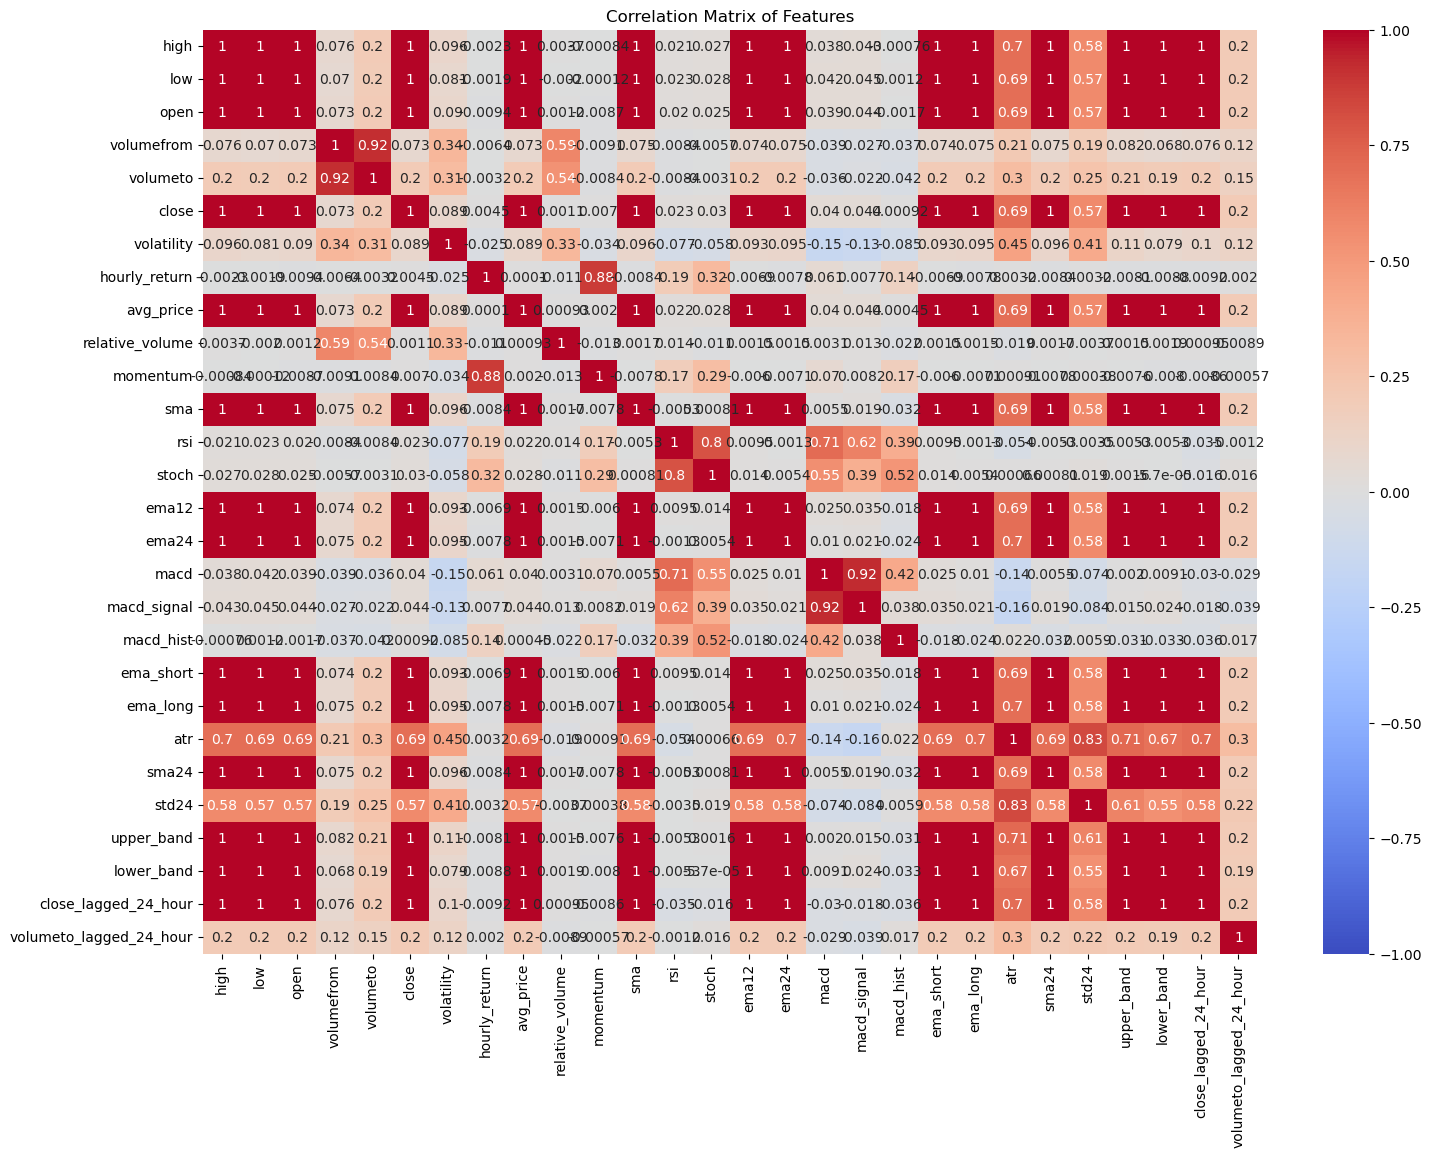

In [29]:
fig, ax3 = plt.subplots(figsize=(17, 12))
correlation_matrix = token.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Features')
plt.show()


In [30]:
# Comprehensive Feature Inclusion Technique

X = token.drop(columns=['close'])

y = token['close']


In [31]:
# Train-test split
split_idx = int(len(token) * 0.8)
X_train = X[:split_idx]
y_train = y[:split_idx]
X_test = X[split_idx:]
y_test = y[split_idx:]

In [32]:
# Validation split
val_idx = int(len(X_train) * 0.8)
X_val = X_train[val_idx:]
y_val = y_train[val_idx:]
X_train = X_train[:val_idx]
y_train = y_train[:val_idx]

In [33]:
# Applying the Standard Scaling Normalization Technique

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


In [34]:
# Sequence creation with Time steps

def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 10
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, time_steps)
X_val_seq, y_val_seq = create_sequences(X_val_scaled, y_val, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, time_steps)

In [35]:
# Model creation for Simple RNN

model = Sequential()
model.add(SimpleRNN(units=70, activation='relu', input_shape=(time_steps, X_train_scaled.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(units=1))



# Compiling the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='mean_squared_error')

# Training the model

history = model.fit(X_train_seq, y_train_seq, epochs=50, validation_data=(X_val_seq, y_val_seq), batch_size=32)


Epoch 1/50
714/714 [==============================] - 2s 2ms/step - loss: 63955980.0000 - val_loss: 4845570.5000
Epoch 2/50
714/714 [==============================] - 1s 2ms/step - loss: 7588247.0000 - val_loss: 1030045.1250
Epoch 3/50
714/714 [==============================] - 1s 2ms/step - loss: 5821397.5000 - val_loss: 980050.4375
Epoch 4/50
714/714 [==============================] - 1s 2ms/step - loss: 5360201.5000 - val_loss: 477804.5000
Epoch 5/50
714/714 [==============================] - 1s 2ms/step - loss: 4938471.5000 - val_loss: 368047.1562
Epoch 6/50
714/714 [==============================] - 1s 2ms/step - loss: 4701748.0000 - val_loss: 234172.0469
Epoch 7/50
714/714 [==============================] - 1s 2ms/step - loss: 4932048.0000 - val_loss: 272552.4062
Epoch 8/50
714/714 [==============================] - 1s 2ms/step - loss: 4927287.0000 - val_loss: 696756.0625
Epoch 9/50
714/714 [==============================] - 1s 2ms/step - loss: 4752742.5000 - val_loss: 152666.640

In [36]:

# Simple RNN Model Evaluation on test data

test_loss = model.evaluate(X_test_seq, y_test_seq)
print('Test Loss:', test_loss)

# Model predictions on test data

y_pred = model.predict(X_test_seq)


223/223 [==============================] - 0s 934us/step - loss: 876050.2500
Test Loss: 876050.25
223/223 [==============================] - 0s 924us/step


In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 70)                6860      
                                                                 
 dropout (Dropout)           (None, 70)                0         
                                                                 
 dense (Dense)               (None, 1)                 71        
                                                                 
Total params: 6931 (27.07 KB)
Trainable params: 6931 (27.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [38]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_elements = y_true != 0
    return np.mean(np.abs((y_true[non_zero_elements] - y_pred[non_zero_elements]) / y_true[non_zero_elements])) * 100




# Evaluation Metrics Calculation

mae = mean_absolute_error(y_test_seq, y_pred)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_seq, y_pred)
mape = mean_absolute_percentage_error(y_test_seq, y_pred)


# Printing Evaluation Metrics

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)
print("Mean Absolute Percentage Error (MAPE):", mape)


Mean Absolute Error (MAE): 844.7571564143583
Mean Squared Error (MSE): 876050.3089790056
Root Mean Squared Error (RMSE): 935.9755920850744
R-squared (R2): 0.882856285337178
Mean Absolute Percentage Error (MAPE): 13.500331081347802


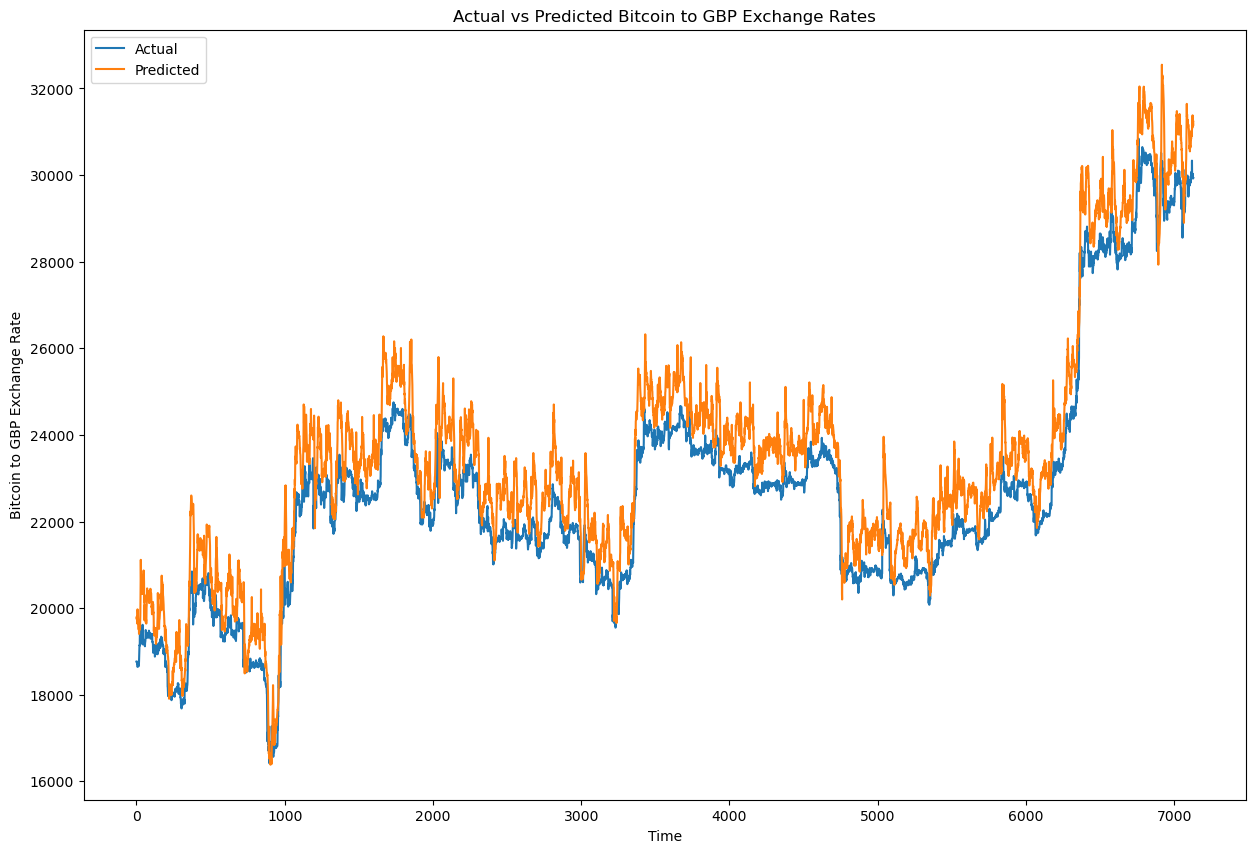

In [39]:
# Actual vs Predicted Values Plot

plt.figure(figsize=(15, 10))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Bitcoin to GBP Exchange Rate')
plt.title('Actual vs Predicted Bitcoin to GBP Exchange Rates')
plt.legend()
plt.show()


In [40]:

# Creating Traces

trace1 = go.Scatter(
    y = history.history['loss'],
    mode = 'lines',
    name = 'Training Loss'
)
trace2 = go.Scatter(
    y = history.history['val_loss'],
    mode = 'lines',
    name = 'Validation Loss'
)

# Adding Traces and Creating Figure

fig = make_subplots(specs=[[{"secondary_y": False}]])
fig.add_trace(trace1)
fig.add_trace(trace2)

# Updating the layout

fig.update_layout(
    title='Training and Validation Loss for Simple RNN',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Legend'
)

# Show the plot
fig.show()


In [41]:
# LSTM Model parameters

time_steps = 10  # the time steps used in our sequence creation
n_features = X_train_scaled.shape[1]

# LSTM model creation

model_lstm = Sequential()
model_lstm.add(LSTM(units=70, activation='relu', input_shape=(time_steps, n_features)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

# Compiling the LSTM model

model_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   loss='mean_squared_error')

# Training the LSTM model

history_lstm = model_lstm.fit(X_train_seq, y_train_seq, epochs=50, 
                              validation_data=(X_val_seq, y_val_seq), batch_size=32)



Epoch 1/50
714/714 [==============================] - 3s 3ms/step - loss: 60496884.0000 - val_loss: 5801264.5000
Epoch 2/50
714/714 [==============================] - 2s 3ms/step - loss: 5861547.5000 - val_loss: 1611202.2500
Epoch 3/50
714/714 [==============================] - 3s 4ms/step - loss: 5297737.0000 - val_loss: 1331095.6250
Epoch 4/50
714/714 [==============================] - 2s 3ms/step - loss: 4960077.5000 - val_loss: 2435206.2500
Epoch 5/50
714/714 [==============================] - 2s 3ms/step - loss: 4806151.5000 - val_loss: 996319.9375
Epoch 6/50
714/714 [==============================] - 2s 3ms/step - loss: 4716322.0000 - val_loss: 582641.0625
Epoch 7/50
714/714 [==============================] - 2s 3ms/step - loss: 4930637.5000 - val_loss: 504079.6250
Epoch 8/50
714/714 [==============================] - 3s 4ms/step - loss: 4833888.5000 - val_loss: 416261.1562
Epoch 9/50
714/714 [==============================] - 2s 3ms/step - loss: 4546455.5000 - val_loss: 492925.3

In [42]:

# LSTM Model Evaluation Test data

test_loss_lstm = model_lstm.evaluate(X_test_seq, y_test_seq)
print('Test Loss (LSTM):', test_loss_lstm)

# LSTM Model Predictions on test data

y_pred_lstm = model_lstm.predict(X_test_seq)


223/223 [==============================] - 0s 1ms/step - loss: 206098.8125
Test Loss (LSTM): 206098.8125
223/223 [==============================] - 0s 1ms/step


In [43]:
model_lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70)                27440     
                                                                 
 dropout_1 (Dropout)         (None, 70)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 27511 (107.46 KB)
Trainable params: 27511 (107.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [44]:

# # Evaluation Metrics Calculation for the LSTM model

mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
r2_lstm = r2_score(y_test_seq, y_pred_lstm)
mape_lstm = mean_absolute_percentage_error(y_test_seq, y_pred_lstm)


# Printing Evaluation Metrics for the LSTM model

print("Mean Absolute Error (MAE) - LSTM:", mae_lstm)
print("Mean Squared Error (MSE) - LSTM:", mse_lstm)
print("Root Mean Squared Error (RMSE) - LSTM:", rmse_lstm)
print("R-squared (R2) - LSTM:", r2_lstm)
print("Mean Absolute Percentage Error (MAPE) - LSTM:", mape_lstm)


Mean Absolute Error (MAE) - LSTM: 356.27991664840465
Mean Squared Error (MSE) - LSTM: 206098.7033194203
Root Mean Squared Error (RMSE) - LSTM: 453.98095039265723
R-squared (R2) - LSTM: 0.9724408890145071
Mean Absolute Percentage Error (MAPE) - LSTM: 12.174050355262793


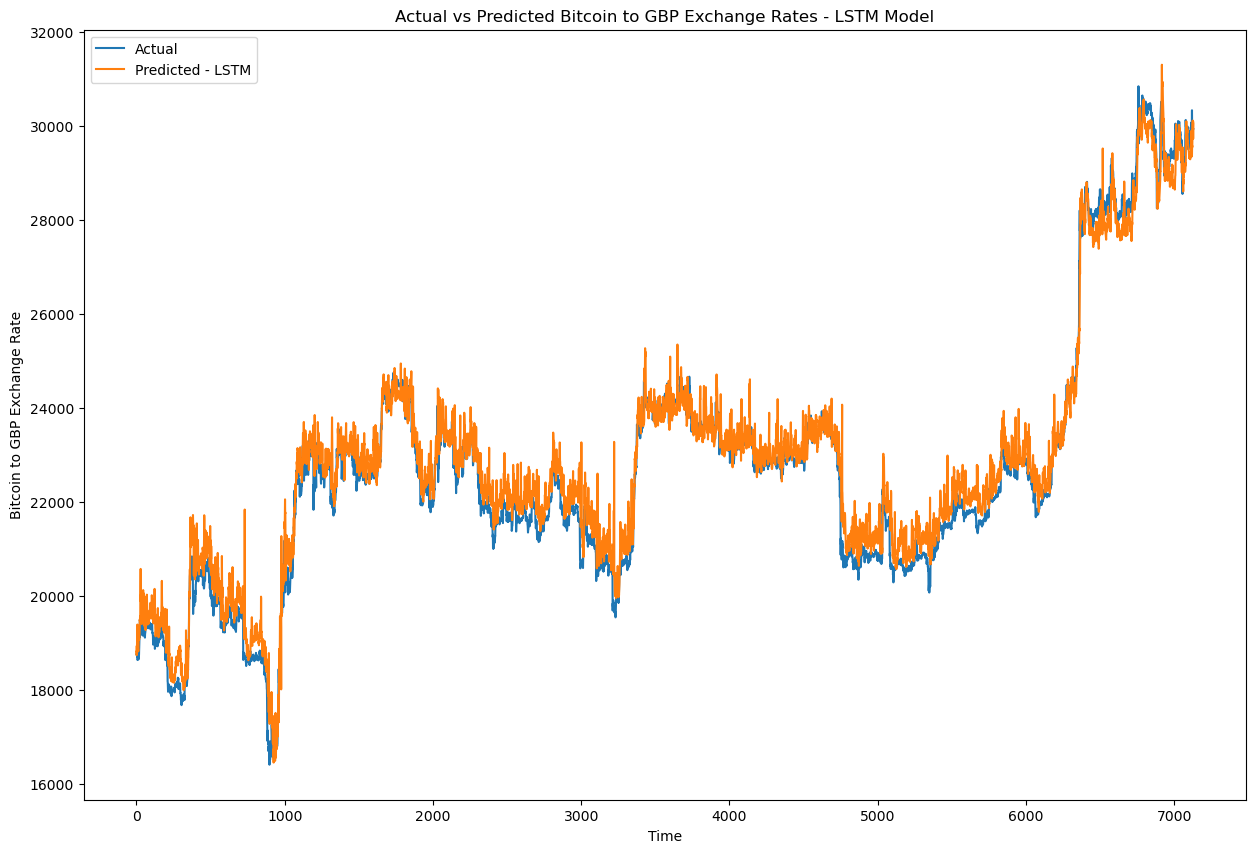

In [45]:

# Actual Plot  vs Predicted Plot for LSTM

plt.figure(figsize=(15, 10))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_lstm, label='Predicted - LSTM')
plt.xlabel('Time')
plt.ylabel('Bitcoin to GBP Exchange Rate')
plt.title('Actual vs Predicted Bitcoin to GBP Exchange Rates - LSTM Model')
plt.legend()
plt.show()


In [46]:
# Creating Plotly visualization for the LSTM model

trace1_lstm = go.Scatter(
    y = history_lstm.history['loss'],
    mode = 'lines',
    name = 'LSTM Training Loss'
)
trace2_lstm = go.Scatter(
    y = history_lstm.history['val_loss'],
    mode = 'lines',
    name = 'LSTM Validation Loss'
)

fig_lstm = make_subplots(specs=[[{"secondary_y": False}]])
fig_lstm.add_trace(trace1_lstm)
fig_lstm.add_trace(trace2_lstm)

fig_lstm.update_layout(
    title='Training and Validation Loss for LSTM',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Legend'
)

fig_lstm.show()


In [47]:

# Model parameters for BI_LSTM

time_steps = 10  # the time steps in our sequence creation
n_features = X_train_scaled.shape[1]


# Bidirectional LSTM model creation

model_bilstm = Sequential()
model_bilstm.add(Bidirectional(LSTM(units=70, activation='relu'), input_shape=(time_steps, n_features)))
model_bilstm.add(Dropout(0.2))
model_bilstm.add(Dense(units=1))


# Compiling the Bidirectional LSTM model

model_bilstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                     loss='mean_squared_error')


# Training the Bidirectional LSTM model

history_bilstm = model_bilstm.fit(X_train_seq, y_train_seq, epochs=50, 
                                  validation_data=(X_val_seq, y_val_seq), batch_size=32)



Epoch 1/50
714/714 [==============================] - 5s 4ms/step - loss: 53821352.0000 - val_loss: 4798226.0000
Epoch 2/50
714/714 [==============================] - 3s 4ms/step - loss: 3579849.0000 - val_loss: 1452824.1250
Epoch 3/50
714/714 [==============================] - 3s 4ms/step - loss: 2725132.2500 - val_loss: 680407.3125
Epoch 4/50
714/714 [==============================] - 3s 4ms/step - loss: 2704762.2500 - val_loss: 522525.8438
Epoch 5/50
714/714 [==============================] - 3s 4ms/step - loss: 2608317.5000 - val_loss: 643069.0625
Epoch 6/50
714/714 [==============================] - 3s 4ms/step - loss: 2631562.2500 - val_loss: 244883.4688
Epoch 7/50
714/714 [==============================] - 3s 4ms/step - loss: 2488655.2500 - val_loss: 380873.5938
Epoch 8/50
714/714 [==============================] - 3s 4ms/step - loss: 2641154.7500 - val_loss: 481293.2500
Epoch 9/50
714/714 [==============================] - 3s 4ms/step - loss: 2595213.2500 - val_loss: 203413.781

In [48]:
# Evaluating the Bidirectional LSTM model on test data

test_loss_bilstm = model_bilstm.evaluate(X_test_seq, y_test_seq)
print('Test Loss (BiLSTM):', test_loss_bilstm)

# Making predictions on test data using the Bidirectional LSTM model

y_pred_bilstm = model_bilstm.predict(X_test_seq)


223/223 [==============================] - 0s 2ms/step - loss: 134413.9531
Test Loss (BiLSTM): 134413.953125
223/223 [==============================] - 1s 2ms/step


In [49]:
model_bilstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirection  (None, 140)               54880     
 al)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 140)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 141       
                                                                 
Total params: 55021 (214.93 KB)
Trainable params: 55021 (214.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [50]:
# # Evaluation Metrics Calculation for the Bidirectional LSTM model

mae_bilstm = mean_absolute_error(y_test_seq, y_pred_bilstm)
mse_bilstm = mean_squared_error(y_test_seq, y_pred_bilstm)
rmse_bilstm = np.sqrt(mse_bilstm)
r2_bilstm = r2_score(y_test_seq, y_pred_bilstm)
mape_bilstm = mean_absolute_percentage_error(y_test_seq, y_pred_bilstm)


# Bidirectional LSTM model evaluation

print("Mean Absolute Error (MAE) - BiLSTM:", mae_bilstm)
print("Mean Squared Error (MSE) - BiLSTM:", mse_bilstm)
print("Root Mean Squared Error (RMSE) - BiLSTM:", rmse_bilstm)
print("R-squared (R2) - BiLSTM:", r2_bilstm)
print("Mean Absolute Percentage Error (MAPE) - Bi-LSTM:", mape_bilstm)


Mean Absolute Error (MAE) - BiLSTM: 290.6401141797423
Mean Squared Error (MSE) - BiLSTM: 134413.90922427707
Root Mean Squared Error (RMSE) - BiLSTM: 366.6250253655321
R-squared (R2) - BiLSTM: 0.9820264379025971
Mean Absolute Percentage Error (MAPE) - Bi-LSTM: 12.519225962082897


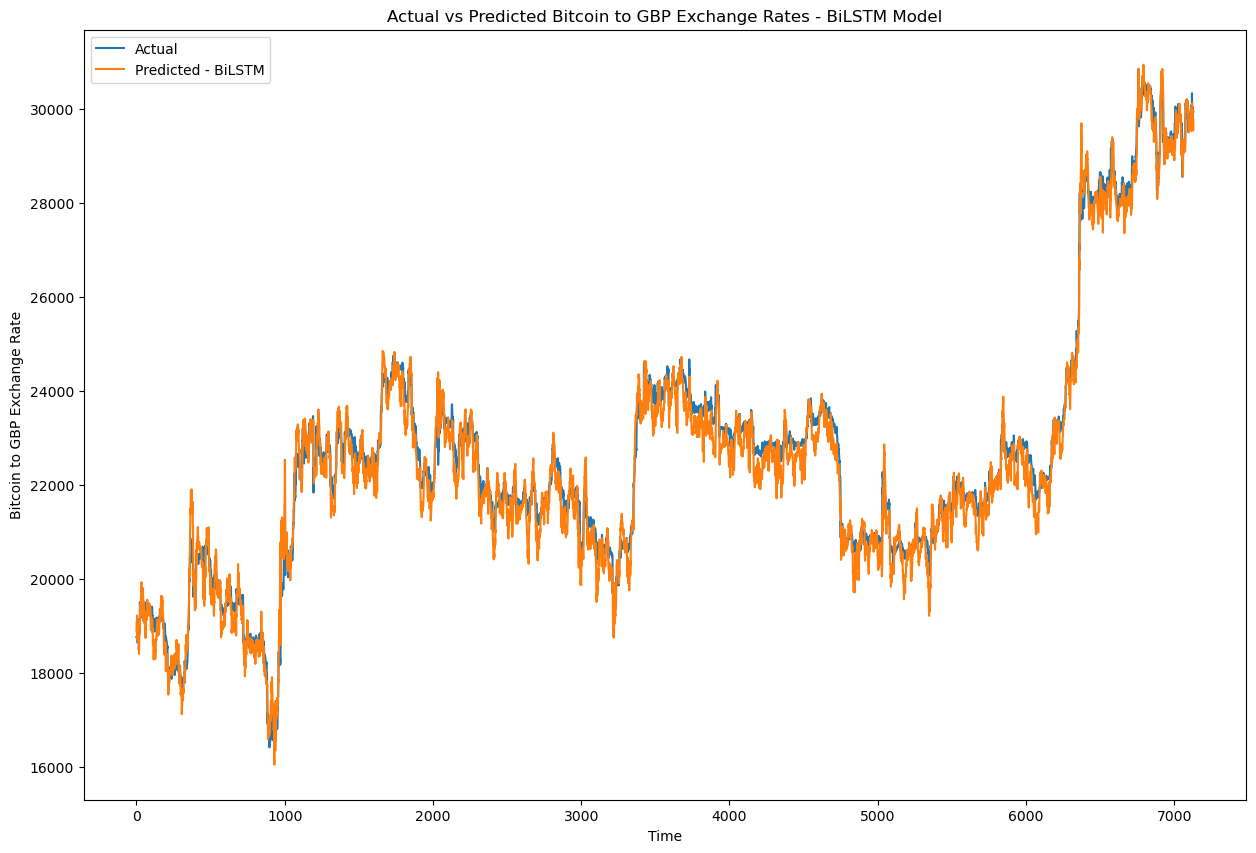

In [51]:
# Actual vs Predicted values plot for BiLSTM model

plt.figure(figsize=(15, 10))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_bilstm, label='Predicted - BiLSTM')
plt.xlabel('Time')
plt.ylabel('Bitcoin to GBP Exchange Rate')
plt.title('Actual vs Predicted Bitcoin to GBP Exchange Rates - BiLSTM Model')
plt.legend()
plt.show()


In [52]:
# Creating Plotly visualization for the Bi-LSTM model

trace1_bilstm = go.Scatter(
    y = history_bilstm.history['loss'],
    mode = 'lines',
    name = 'Bi-LSTM Training Loss'
)
trace2_bilstm = go.Scatter(
    y = history_bilstm.history['val_loss'],
    mode = 'lines',
    name = 'Bi-LSTM Validation Loss'
)

fig_bilstm = make_subplots(specs=[[{"secondary_y": False}]])
fig_bilstm.add_trace(trace1_bilstm)
fig_bilstm.add_trace(trace2_bilstm)

fig_bilstm.update_layout(
    title='Training and Validation Loss for Bi-LSTM',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Legend'
)

fig_bilstm.show()


In [53]:

# Model parameters for stacked LSTM

time_steps = 10  # the time step in our sequence creation
n_features = X_train_seq.shape[2]  # number of features in the dataset


# Stacked LSTM model creation

model_stacked_lstm = Sequential()
model_stacked_lstm.add(LSTM(units=70, activation='relu', return_sequences=True, 
                            input_shape=(time_steps, n_features)))
model_stacked_lstm.add(Dropout(0.2))
model_stacked_lstm.add(LSTM(units=70, activation='relu'))
model_stacked_lstm.add(Dropout(0.2))
model_stacked_lstm.add(Dense(units=1))


# Compiling the Stacked LSTM model

model_stacked_lstm.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                           loss='mean_squared_error')

# Training the Stacked LSTM model

history_stacked_lstm = model_stacked_lstm.fit(X_train_seq, y_train_seq, epochs=50, 
                                              validation_data=(X_val_seq, y_val_seq),
                                              batch_size=32)  


Epoch 1/50
714/714 [==============================] - 6s 6ms/step - loss: 51024168.0000 - val_loss: 3818199.7500
Epoch 2/50
714/714 [==============================] - 4s 6ms/step - loss: 6022247.0000 - val_loss: 799383.3125
Epoch 3/50
714/714 [==============================] - 4s 6ms/step - loss: 5431594.0000 - val_loss: 485019.8438
Epoch 4/50
714/714 [==============================] - 4s 6ms/step - loss: 5224987.5000 - val_loss: 624957.1250
Epoch 5/50
714/714 [==============================] - 4s 6ms/step - loss: 5094511.0000 - val_loss: 349150.1250
Epoch 6/50
714/714 [==============================] - 5s 7ms/step - loss: 5076667.0000 - val_loss: 918471.6250
Epoch 7/50
714/714 [==============================] - 4s 6ms/step - loss: 4750169.5000 - val_loss: 509940.4062
Epoch 8/50
714/714 [==============================] - 4s 6ms/step - loss: 4719871.0000 - val_loss: 560822.6250
Epoch 9/50
714/714 [==============================] - 4s 6ms/step - loss: 5424513.5000 - val_loss: 396328.0625

In [54]:
# Evaluating the Stacked LSTM model on test data

test_loss_stacked_lstm = model_stacked_lstm.evaluate(X_test_seq, y_test_seq)
print('Test Loss (Stacked LSTM):', test_loss_stacked_lstm)


# Making predictions on test data using the Stacked LSTM model

y_pred_stacked_lstm = model_stacked_lstm.predict(X_test_seq)

223/223 [==============================] - 0s 2ms/step - loss: 101880.5078
Test Loss (Stacked LSTM): 101880.5078125
223/223 [==============================] - 1s 4ms/step


In [55]:
model_stacked_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 10, 70)            27440     
                                                                 
 dropout_3 (Dropout)         (None, 10, 70)            0         
                                                                 
 lstm_3 (LSTM)               (None, 70)                39480     
                                                                 
 dropout_4 (Dropout)         (None, 70)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 71        
                                                                 
Total params: 66991 (261.68 KB)
Trainable params: 66991 (261.68 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [56]:

# # Evaluation Metrics Calculation for the Stacked LSTM model

mae_stacked_lstm = mean_absolute_error(y_test_seq, y_pred_stacked_lstm)
mse_stacked_lstm = mean_squared_error(y_test_seq, y_pred_stacked_lstm)
rmse_stacked_lstm = np.sqrt(mse_stacked_lstm)
r2_stacked_lstm = r2_score(y_test_seq, y_pred_stacked_lstm)
mape_stacked_lstm = mean_absolute_percentage_error(y_test_seq, y_pred_stacked_lstm)


# Printing Evaluation metrics for the Stacked LSTM model

print("Mean Absolute Error (MAE) - Stacked LSTM:", mae_stacked_lstm)
print("Mean Squared Error (MSE) - Stacked LSTM:", mse_stacked_lstm)
print("Root Mean Squared Error (RMSE) - Stacked LSTM:", rmse_stacked_lstm)
print("R-squared (R2) - Stacked LSTM:", r2_stacked_lstm)
print("Mean Absolute Percentage Error (MAPE) - Stacked LSTM:", mape_stacked_lstm)


Mean Absolute Error (MAE) - Stacked LSTM: 253.5726474458713
Mean Squared Error (MSE) - Stacked LSTM: 101880.51331423124
Root Mean Squared Error (RMSE) - Stacked LSTM: 319.1872699752157
R-squared (R2) - Stacked LSTM: 0.9863767392590804
Mean Absolute Percentage Error (MAPE) - Stacked LSTM: 12.27929274330829


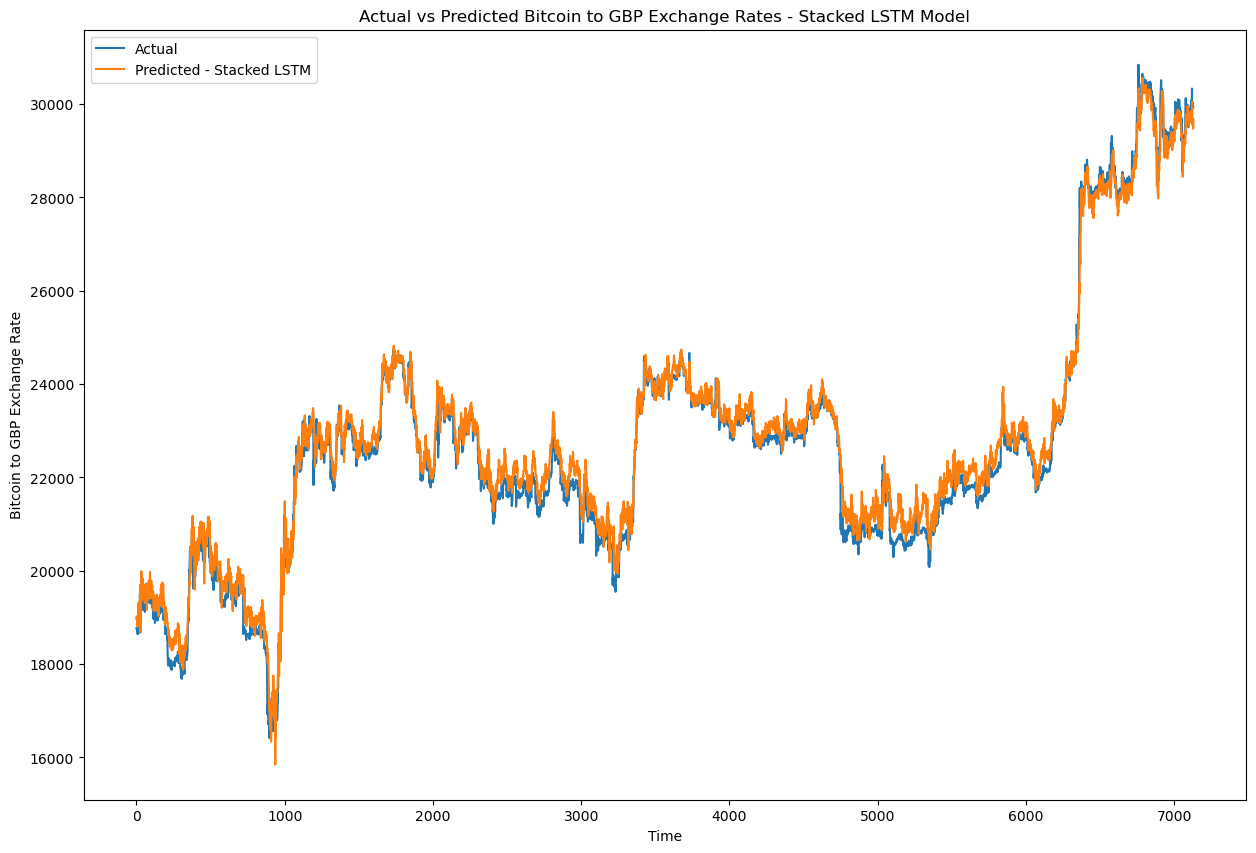

In [57]:
# Actual vs Predicted values for Stacked LSTM

plt.figure(figsize=(15, 10))
plt.plot(y_test_seq, label='Actual')
plt.plot(y_pred_stacked_lstm, label='Predicted - Stacked LSTM')
plt.xlabel('Time')
plt.ylabel('Bitcoin to GBP Exchange Rate')
plt.title('Actual vs Predicted Bitcoin to GBP Exchange Rates - Stacked LSTM Model')
plt.legend()
plt.show()


In [58]:
# Creating Plotly visualization for the Stacked LSTM model

trace1_stacked_lstm = go.Scatter(
    y = history_stacked_lstm.history['loss'],
    mode = 'lines',
    name = 'Stacked LSTM Training Loss'
)
trace2_stacked_lstm = go.Scatter(
    y = history_stacked_lstm.history['val_loss'],
    mode = 'lines',
    name = 'Stacked LSTM Validation Loss'
)

fig_stacked_lstm = make_subplots(specs=[[{"secondary_y": False}]])
fig_stacked_lstm.add_trace(trace1_stacked_lstm)
fig_stacked_lstm.add_trace(trace2_stacked_lstm)

fig_stacked_lstm.update_layout(
    title='Training and Validation Loss for Stacked LSTM',
    xaxis_title='Epochs',
    yaxis_title='Loss',
    legend_title='Legend'
)

fig_stacked_lstm.show()
